In [225]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

$$R(x + δ) = \frac{(2 + δ²(V(x) - E))R(x) - (1 - δ/x) R(x - δ)}{1 + \frac{δ}{x}}$$

In [366]:
def build_wavefunction(E: float, V: Callable[[float], float], max_x: float, δ: float, r1=1):
    N = int(max_x // δ)
    R = np.array([0, r1])
    for i in range(1, N):
        xi = i * δ
        ri = ((2 + δ**2 * (V(xi) - E)) * R[-1] - (1 - δ/xi) * R[-2]) / (1 + δ/xi)
        R = np.append(R, ri)

    # Normalization
    # R = R / np.sum([δ * R])
    return R

def find_eigenenergy(E1: float, E2: float, V: Callable[[float], float], max_x: float,
                       δ: float, r1: float = 1.0, tolerance: float = 0.001, maximum_iterations: int = 1000, show_progress=False):
    R1 = build_wavefunction(E1, V, max_x, δ, r1)
    R2 = build_wavefunction(E2, V, max_x, δ, r1)

    if show_progress:
        plt.rcParams.update({"font.family": "Times New Roman", "mathtext.fontset": "cm"})
        X = δ * np.arange(0, int(max_x // δ) + 1)
        fig, ax = plt.subplots(dpi=100)
        ax.plot(X, R1, label='Numerical $R(x)$ for $E1$')
        ax.plot(X, R2, label='Numerical $R(x)$ for $E2$')
        ax.axhline(0, c='k', lw=1)
        ax.legend()
        
        plt.show()
    if R1[-1] * R2[-1] > 0:
        raise ValueError("Binary search method requires E1, E2 such that the signs of the final value of the numerical wavefunctions differ.")
    i = 1
    while i <= maximum_iterations:
        E3 = (E1 + E2) / 2
        R3 = build_wavefunction(E3, V, max_x, δ, r1)
        if show_progress:
            print(i, E3)
        if np.abs(R3[-1]) < tolerance:
            return E3, R3
        if R1[-1] * R3[-1] > 0:
            E1 = E3
            R1 = build_wavefunction(E1, V, max_x, δ, r1)
        if R2[-1] * R3[-1] > 0:
            E2 = E3
            R2 = build_wavefunction(E2, V, max_x, δ, r1)
        i += 1
    raise RecursionError("Maximum number of iterations exceeded without satisfying tolerance.")

In [367]:
L = np.random.choice(20)

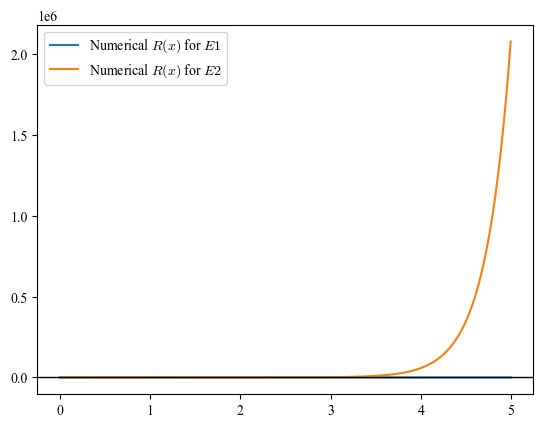

1 -7.505
2 -3.7575
3 -1.8837499999999998
4 -0.9468749999999999
5 -1.4153124999999998
6 -1.1810937499999998
7 -1.063984375
8 -1.0054296875
9 -0.9761523437499999
10 -0.9907910156249999
11 -0.9981103515624999
12 -0.9944506835937499
13 -0.9926208496093749
14 -0.9935357666015624
15 -0.9930783081054686
16 -0.9928495788574218
17 -0.9927352142333983
18 -0.99279239654541
19 -0.9927638053894041
-0.9927638053894041


In [405]:
# Physical parameters
L = 0
n = 1
E1 = -0.01
E2 = -15
V_func = lambda x: L * (L + 1) / x**2 - 2 / x

# Numerical method parameters
max_x = 5
δ = 0.005

# Numerical method
E, R = find_eigenenergy(E1, E2, V_func, max_x, δ, tolerance=0.00001, show_progress=True)
print(E)
# print(f"Energies: expected: {E}, actual: {-(n)**(-2)}")

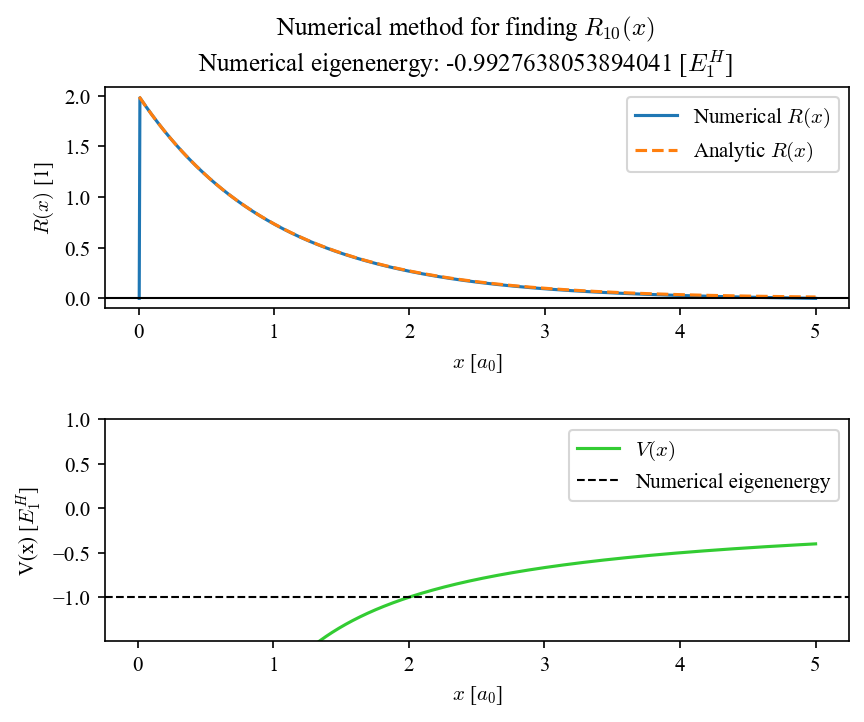

In [406]:
from sympy.physics.hydrogen import R_nl
from sympy.abc import x
from sympy import lambdify

N = max_x / δ
X = δ * np.arange(1, N + 1)
V = V_func(X[1:])

R_analytic = lambdify(x, R_nl(n, L, x, Z=1))
R_analytic = R_analytic(X)

# Rescaling for normalization
R = R * R_analytic[2] / R[2]

plt.rcParams.update({"font.family": "Times New Roman", "mathtext.fontset": "cm"})
fig, axs = plt.subplot_mosaic([["R"], ["V"]], dpi=150)
plt.suptitle(f"Numerical method for finding $R_{{{n}{L}}}(x)$\nNumerical eigenenergy: {E} [$E_1^H$]")
ylabels = ["$R(x)$ [1]", "V(x) [$E_1^H$]"]

axs["R"].plot(X, R, label='Numerical $R(x)$')
axs["R"].plot(X, R_analytic, label='Analytic $R(x)$', ls='--')
axs["R"].axhline(0, c='k', lw=1)
# axs["R"].axvline(turning_point, c='k', ls=':', lw=1, label='Classical turning point')

axs["V"].plot(X[1:], V, label="$V(x)$", c='#3c3')
axs["V"].axhline(E, c='k', label='Numerical eigenenergy', ls='--', lw=1)
padding = -0.5
axs["V"].set_ylim([E + padding, 1])

for ax_label, ylabel in zip(axs, ylabels):
    axs[ax_label].set(xlabel="$x$ [$a_0$]", ylabel=ylabel)
    axs[ax_label].legend()

plt.subplots_adjust(hspace=0.5)